In [2]:
import pandas as pd

In [3]:
%run setup.ipynb

In [5]:
predictions = pd.read_csv(f"../data/predictions/predictions-{11}-{6}.csv")

predictions.drop(predictions.columns[0], axis=1, inplace=True)
predictions.rename(columns={list(predictions)[0]:'date'}, inplace=True)
predictions['date'] = pd.to_datetime(predictions['date'], errors='coerce')

In [7]:
sales = pd.DataFrame(predictions.sales)

errors = predictions.drop(predictions.columns[[0, 1, 2]], axis=1)\
    .sub(sales.sales, axis=0)\
        .divide(sales.sales, axis=0) * 100

In [8]:
errors

,autoreg,exp_smooth,exp_smooth_multi,ardl,prophet,xgb_preds
0,-4.100212,-0.090401,6.737727,-19.227368,-10.199980,20.524074
1,40.951577,54.827076,61.618608,17.109615,30.847096,15.482339
2,-12.255485,-13.351602,-10.659800,-31.465567,-15.514811,-24.887552
3,27.276438,28.840420,31.838556,25.196129,22.030022,19.365818
4,-20.604291,-21.299002,-19.500406,-11.820961,-17.893189,-20.877406
...,...,...,...,...,...,...
272401,-14.227338,12.110762,3.708826,-17.137968,-3.190225,-5.223773
272402,-18.017841,8.559487,-4.020399,1.939779,10.040482,12.025831
272403,-44.095974,-23.612159,-31.995787,-18.327666,-5.977197,-5.312405
272404,-29.513416,-3.996342,-15.482399,12.787682,19.459378,11.576532


In [9]:
def create_features(df):
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    
    return X

In [10]:
date_attrs = create_features(predictions)

In [11]:
import matplotlib.pyplot as plt

array([[<AxesSubplot:title={'center':'autoreg'}>,
        <AxesSubplot:title={'center':'exp_smooth'}>],
       [<AxesSubplot:title={'center':'exp_smooth_multi'}>,
        <AxesSubplot:title={'center':'ardl'}>],
       [<AxesSubplot:title={'center':'prophet'}>,
        <AxesSubplot:title={'center':'xgb_preds'}>]], dtype=object)

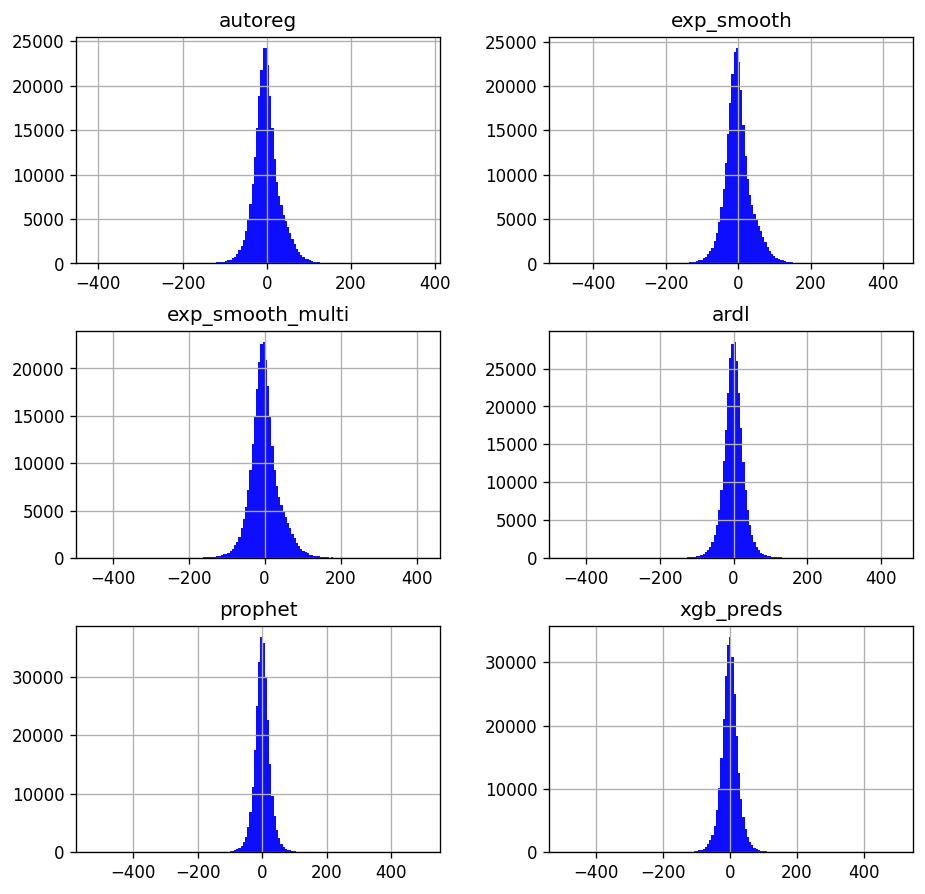

In [12]:
plt.rcParams.update({'figure.figsize':(9,9), 'figure.dpi':120})

errors.diff().hist(bins=150, facecolor='blue', alpha=0.95, )

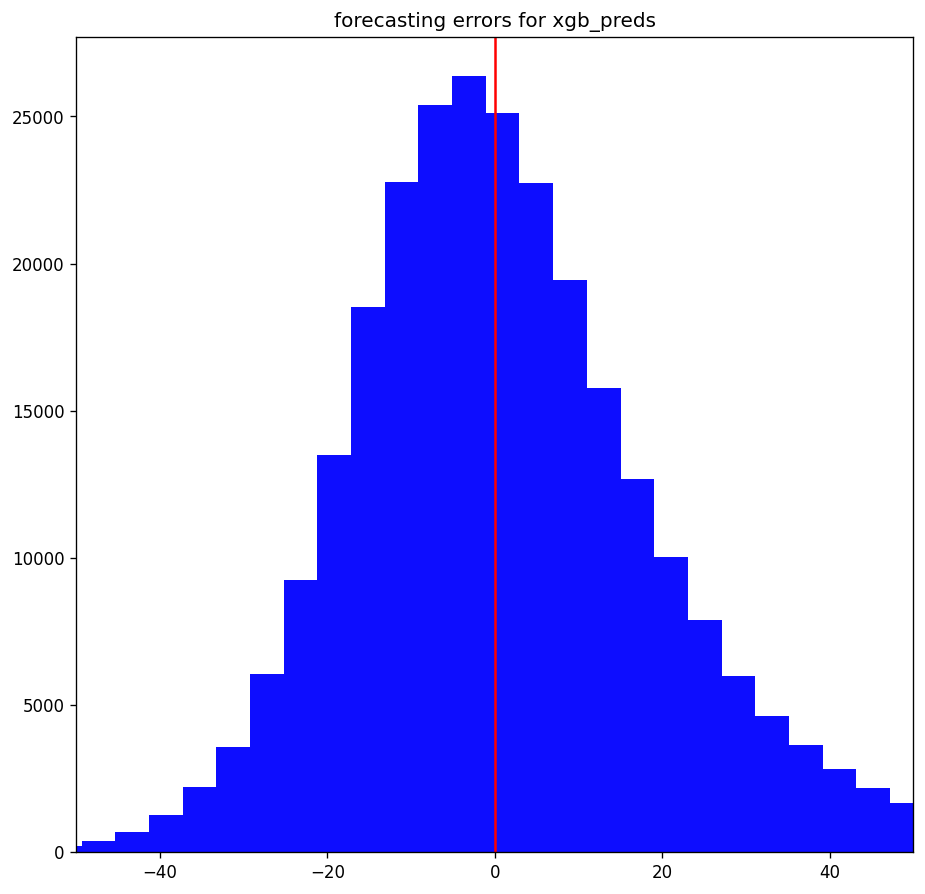

In [13]:
def fcast_errors(col="prophet"):
    plt.hist(errors[col], 150, facecolor='blue', alpha=0.95)
    plt.axvline(x=0, c="red")
    plt.title(f"forecasting errors for {col}")
    plt.xlim((-50, 50))
    plt.show()
    
fcast_errors("xgb_preds")

In [16]:
errors.abs()\
    .mean()\
    .sort_values()
    

prophet             13.628933
xgb_preds           15.374096
ardl                16.232554
exp_smooth          21.166935
exp_smooth_multi    21.384944
autoreg             21.476331
dtype: float64

In [36]:
errors.std()\
    .sort_values()

prophet             18.920430
ardl                21.286953
xgb_preds           21.545096
autoreg             24.230834
exp_smooth          28.616074
exp_smooth_multi    28.983077
dtype: float64

In [21]:

error_plots = pd.concat([predictions.store_item, errors, create_features(predictions)], axis=1)
# for error in error_plots.store_item.unique():
#     temp = error_plots[error_plots.store_item == error]
#     plt.plot(temp.xgb_preds)
error_plots

,store_item,autoreg,exp_smooth,exp_smooth_multi,ardl,prophet,xgb_preds,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,1-1,-4.100212,-0.090401,6.737727,-19.227368,-10.199980,20.524074,6,3,7,2016,185,3,26
1,1-1,40.951577,54.827076,61.618608,17.109615,30.847096,15.482339,0,3,7,2016,186,4,27
2,1-1,-12.255485,-13.351602,-10.659800,-31.465567,-15.514811,-24.887552,1,3,7,2016,187,5,27
3,1-1,27.276438,28.840420,31.838556,25.196129,22.030022,19.365818,2,3,7,2016,188,6,27
4,1-1,-20.604291,-21.299002,-19.500406,-11.820961,-17.893189,-20.877406,3,3,7,2016,189,7,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272401,10-50,-14.227338,12.110762,3.708826,-17.137968,-3.190225,-5.223773,2,4,12,2017,361,27,52
272402,10-50,-18.017841,8.559487,-4.020399,1.939779,10.040482,12.025831,3,4,12,2017,362,28,52
272403,10-50,-44.095974,-23.612159,-31.995787,-18.327666,-5.977197,-5.312405,4,4,12,2017,363,29,52
272404,10-50,-29.513416,-3.996342,-15.482399,12.787682,19.459378,11.576532,5,4,12,2017,364,30,52
